# Pràctica 3: Regressió Logistica


## Avaluació i entregues

### Entregues
Les pràctiques es realitzarán els divendres de 15:00 a 17:00. Cada setmana presentarem nous mètodes i algorismes vistos a la classe de teoria.

L'entrega, es realitzarà el següent dijous abans de les 23:59, és a dir, tindreu les hores de classe més tota una setmana per a realitzar les tasques. Es pujará un .ipynb ja executat, on no només hi hagi codi sinó també text explicatiu de gràfiques, resultats, i analisis. Tingueu en compte que no es valora tant la quantitat, sino la qualitat del que s'hi explica. Hem d'aprendre a extreure el gra de la palla i presentar-ho de forma correcta i concisa.


### Avaluació
Aquesta práctica será molt més dirigida que l'anterior. S'evaluarán els següents conceptes sobre una mateixa base de dades, que tractarà sobre els vins:

* A. Ús LogisticRegression (30%)
* B. Regularitzadors (30%)
* C. Demostració Error de Variance (20%)
* D. Demostració Error de Bias (20%)

Recordeu el què significa el error de Variança i el de bias.

<img src="bias_variance.png" width=600 height=600 />

A continuació us posem un esquelet de codi que podeu tenir com a referència




In [2]:
# Codi esquelet per la pràctica de la 2 sessió: Regressió Lineal i Polinomial

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()


# Visualitzarem només 3 decimals per mostra, i definim el num de files i columnes a mostrar
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('winequalityN.csv')
dataset = dataset.dropna()
dataset['is_red_wine'] = (dataset["type"] == 'red').astype(int)


print("Dimensionalitat de la BBDD:", dataset.shape)


Dimensionalitat de la BBDD: (6463, 14)


A continuació veurem algunes taules i gràfiques per entendre com són les dades que tenim:

In [3]:
display(dataset)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red_wine
0,white,7.000,0.270,0.360,20.700,0.045,45.000,170.000,1.001,3.000,0.450,8.800,6,0
1,white,6.300,0.300,0.340,1.600,0.049,14.000,132.000,0.994,3.300,0.490,9.500,6,0
2,white,8.100,0.280,0.400,6.900,0.050,30.000,97.000,0.995,3.260,0.440,10.100,6,0
3,white,7.200,0.230,0.320,8.500,0.058,47.000,186.000,0.996,3.190,0.400,9.900,6,0
4,white,7.200,0.230,0.320,8.500,0.058,47.000,186.000,0.996,3.190,0.400,9.900,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,red,6.800,0.620,0.080,1.900,0.068,28.000,38.000,0.997,3.420,0.820,9.500,6,1
6492,red,6.200,0.600,0.080,2.000,0.090,32.000,44.000,0.995,3.450,0.580,10.500,5,1
6494,red,6.300,0.510,0.130,2.300,0.076,29.000,40.000,0.996,3.420,0.750,11.000,6,1
6495,red,5.900,0.645,0.120,2.000,0.075,32.000,44.000,0.995,3.570,0.710,10.200,5,1


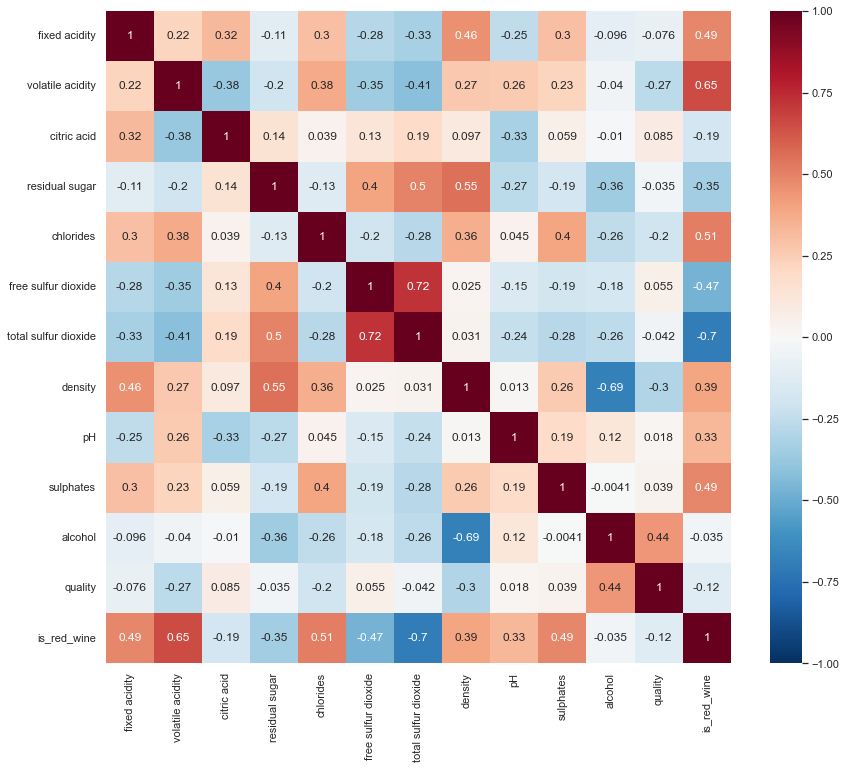

In [4]:
correlation = dataset.corr()
#display(correlation)
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

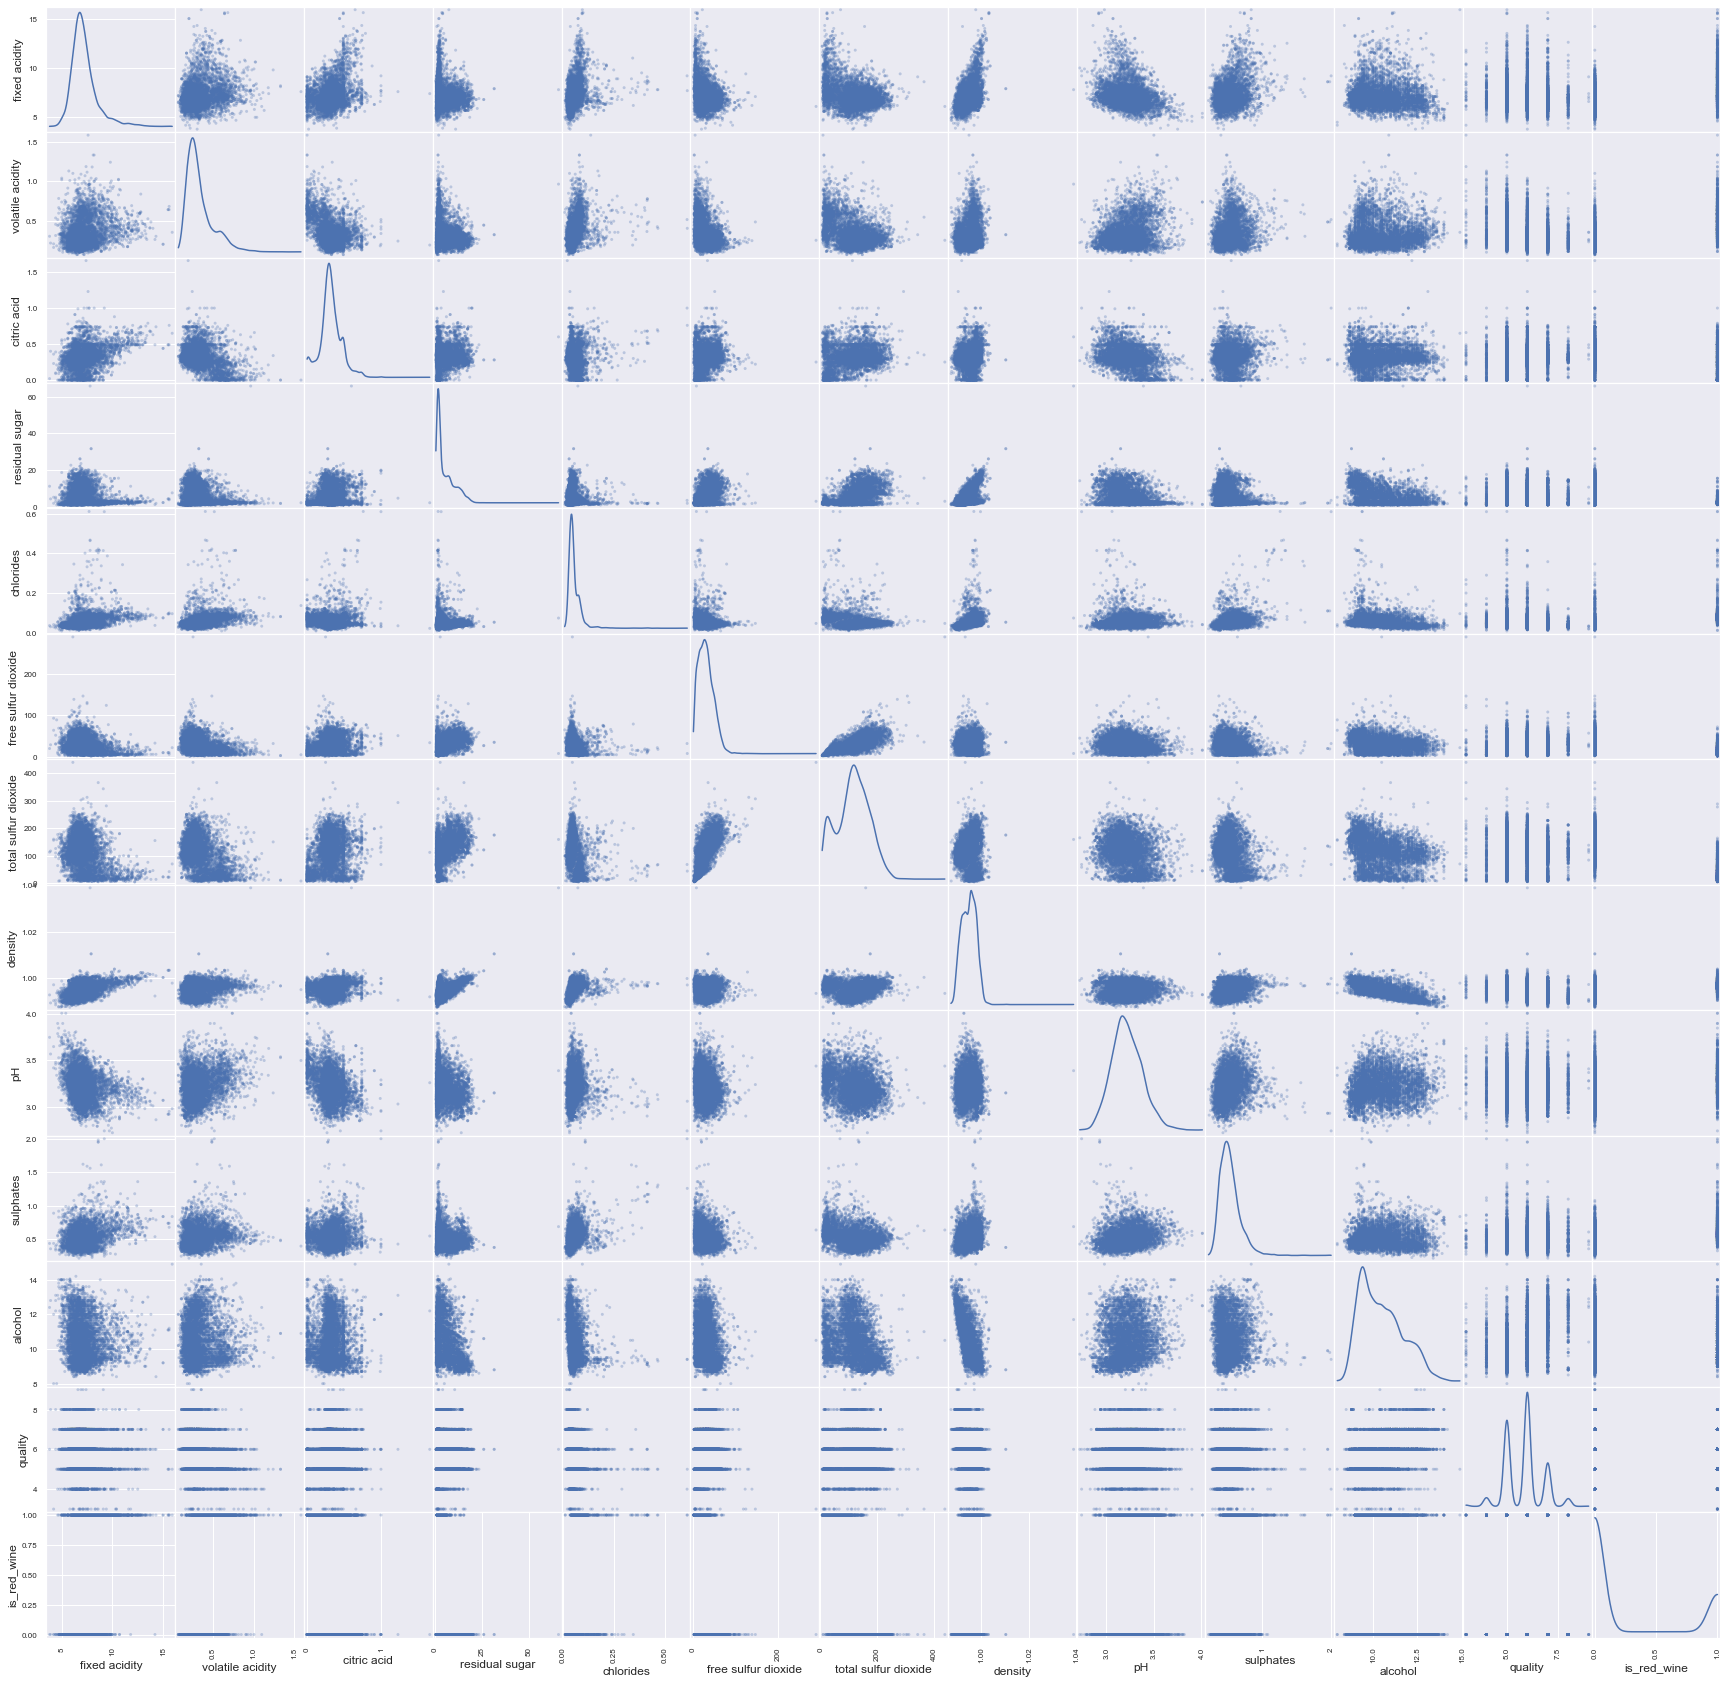

In [5]:
pd.plotting.scatter_matrix(dataset, alpha = 0.3, figsize = (30,30), diagonal = 'kde');

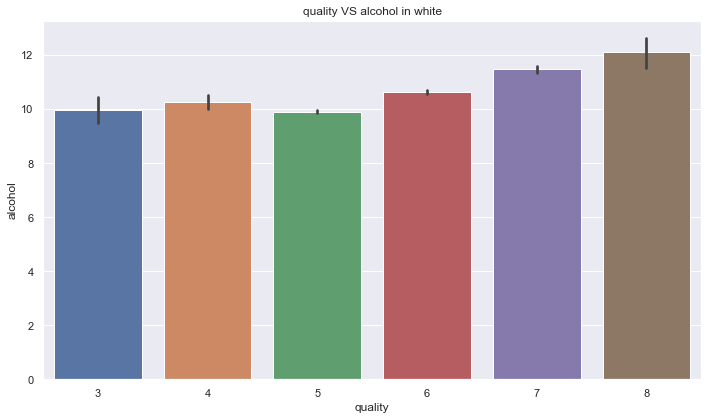

<Figure size 432x288 with 0 Axes>

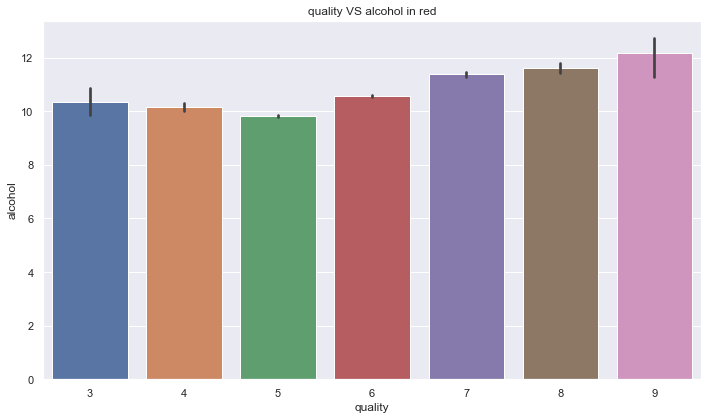

<Figure size 432x288 with 0 Axes>

In [6]:
#We can visualize relationships of discreet values better with a bar plot

fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x='quality', y='alcohol', data=dataset[dataset.type=="red"], ax=axs)
plt.title('quality VS alcohol in white')

plt.tight_layout()
plt.show()
plt.gcf().clear()

fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x='quality', y='alcohol', data=dataset[dataset.type=="white"], ax=axs)
plt.title('quality VS alcohol in red')

plt.tight_layout()
plt.show()
plt.gcf().clear()


Abans de començar amb els exercicis, preparaem les dades per a que sigui una classificació binaria

In [7]:
#Defining the splits for categories. 1-5 will be poor quality, 5-10 will be great
bins = [1,5,10]

#0 for low quality, 1 for average, 2 for great quality
quality_labels=[0,1]
dataset['quality_categorical'] = pd.cut(dataset['quality'], bins=bins, labels=quality_labels, include_lowest=True)
# Split the data into features and target label
quality_raw = dataset['quality_categorical']
features_raw = dataset.drop(['type', 'quality', 'quality_categorical'], axis = 1)


In [8]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_raw, 
                                                    quality_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples. {:.1f}% is positive".format(X_train.shape[0], 100*sum(y_train)/y_train.shape[0]))
print("Testing set has {} samples. {:.1f}% is positive".format(X_test.shape[0], 100*sum(y_test)/y_test.shape[0]))

display(X_test)

Training set has 5170 samples. 63.1% is positive
Testing set has 1293 samples. 64.3% is positive


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_red_wine
3859,7.300,0.250,0.260,7.200,0.048,52.000,207.000,0.996,3.120,0.370,9.200,0
4675,5.700,0.210,0.370,4.500,0.040,58.000,140.000,0.993,3.290,0.620,10.600,0
513,7.400,0.360,0.330,1.400,0.025,27.000,55.000,0.992,3.210,0.330,11.200,0
5490,9.000,0.450,0.490,2.600,0.084,21.000,75.000,0.999,3.350,0.570,9.700,1
4329,6.400,0.230,0.260,8.100,0.054,47.000,181.000,0.995,3.120,0.490,9.400,0
...,...,...,...,...,...,...,...,...,...,...,...,...
410,7.200,0.250,0.390,18.950,0.038,42.000,155.000,1.000,2.970,0.470,9.000,0
4562,5.600,0.180,0.300,10.200,0.028,28.000,131.000,0.995,3.490,0.420,10.800,0
5626,6.400,0.570,0.020,1.800,0.067,4.000,11.000,0.997,3.460,0.680,9.500,1
1248,7.200,0.180,0.310,1.100,0.045,20.000,73.000,0.993,3.320,0.400,10.800,0


In [9]:
X_test

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_red_wine
3859,7.300,0.250,0.260,7.200,0.048,52.000,207.000,0.996,3.120,0.370,9.200,0
4675,5.700,0.210,0.370,4.500,0.040,58.000,140.000,0.993,3.290,0.620,10.600,0
513,7.400,0.360,0.330,1.400,0.025,27.000,55.000,0.992,3.210,0.330,11.200,0
5490,9.000,0.450,0.490,2.600,0.084,21.000,75.000,0.999,3.350,0.570,9.700,1
4329,6.400,0.230,0.260,8.100,0.054,47.000,181.000,0.995,3.120,0.490,9.400,0
...,...,...,...,...,...,...,...,...,...,...,...,...
410,7.200,0.250,0.390,18.950,0.038,42.000,155.000,1.000,2.970,0.470,9.000,0
4562,5.600,0.180,0.300,10.200,0.028,28.000,131.000,0.995,3.490,0.420,10.800,0
5626,6.400,0.570,0.020,1.800,0.067,4.000,11.000,0.997,3.460,0.680,9.500,1
1248,7.200,0.180,0.310,1.100,0.045,20.000,73.000,0.993,3.320,0.400,10.800,0


## A. Ús LogisticRegression (20%)

En aquesta secció us demanem que apliqueu de sklearn el model de [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):

Si feu proves amb diferents parametres, guardeu els resultats que obtingueu en una taula de pandas i els mostreu.

* Guarda resultats de temps, de precisió, de accuracy, tant de train com de test


In [10]:
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


def train_predict_evaluate(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: quality training set
       - X_test: features testing set
       - y_test: quality testing set
    '''
    
    results = {}
    
    """
    Fit/train the learner to the training data using slicing with 'sample_size' 
    using .fit(training_features[:], training_labels[:])
    """
    start = time() # Get start time of training
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size]) #Train the model
    end = time() # Get end time of training
    
    # Calculate the training time
    results['train_time'] = end - start
    
    """
    Get the predictions on the first 300 training samples(X_train), 
    and also predictions on the test set(X_test) using .predict()
    """
    start = time() # Get start time
    predictions_train = learner.predict(X_train[:300])
    predictions_test = learner.predict(X_test)
    plt.plot(predictions_test)
    plt.show()
    
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F1-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5, average='micro')
        
    # Compute F1-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5, average='micro')
       
    cm = confusion_matrix(y_test, predictions_test)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['good', 'bad']); 
    ax.yaxis.set_ticklabels(['good', 'bad']);


    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results


In [11]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_red_wine
count,5170.000,5170.000,5170.000,5170.000,5170.000,5170.000,5170.000,5170.000,5170.000,5170.000,5170.000,5170.000
mean,7.222,0.338,0.320,5.494,0.056,30.605,116.158,0.995,3.216,0.530,10.486,0.243
std,1.295,0.163,0.145,4.813,0.035,17.757,56.306,0.003,0.158,0.149,1.193,0.429
min,3.800,0.080,0.000,0.600,0.009,1.000,6.000,0.987,2.720,0.220,8.000,0.000
25%,6.400,0.230,0.250,1.800,0.038,17.000,79.000,0.992,3.110,0.430,9.500,0.000
50%,7.000,0.290,0.310,3.100,0.047,29.000,119.000,0.995,3.205,0.510,10.300,0.000
75%,7.700,0.400,0.390,8.200,0.064,41.000,155.000,0.997,3.320,0.600,11.300,0.000
max,15.900,1.580,1.660,65.800,0.611,289.000,440.000,1.039,4.010,2.000,14.900,1.000


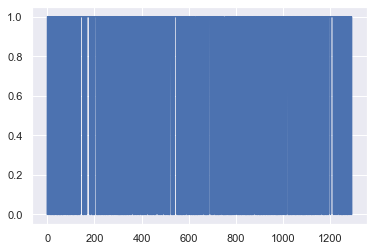

SGDClassifier trained on 5170 samples.


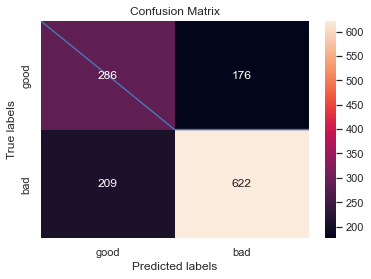

SGDClassifier trained on 5170 samples.


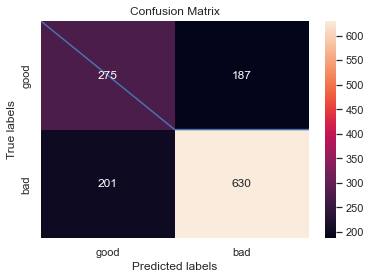

SGDClassifier trained on 5170 samples.


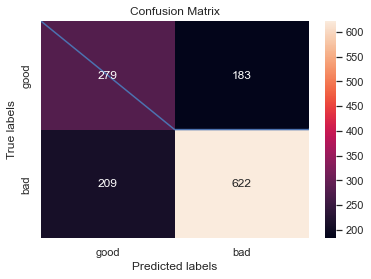

SGDClassifier trained on 5170 samples.


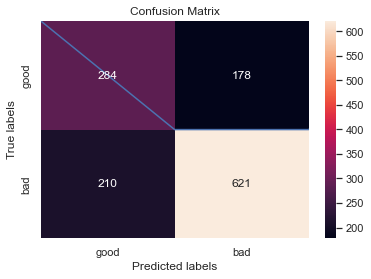

SGDClassifier trained on 5170 samples.


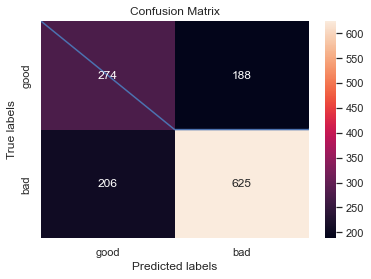

SGDClassifier trained on 5170 samples.


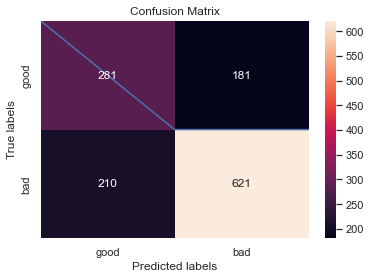

SGDClassifier trained on 5170 samples.


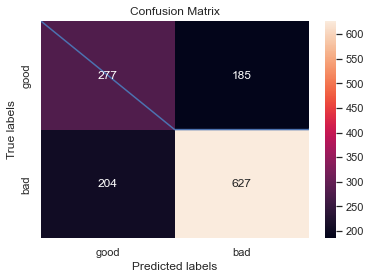

SGDClassifier trained on 5170 samples.
{1e-06: {'train_time': 0.08278107643127441, 'pred_time': 0.12171006202697754, 'acc_train': 0.74, 'acc_test': 0.7022428460943542, 'f_train': 0.74, 'f_test': 0.7022428460943542}, 1e-05: {'train_time': 0.09320259094238281, 'pred_time': 0.07198691368103027, 'acc_train': 0.7366666666666667, 'acc_test': 0.699922660479505, 'f_train': 0.7366666666666667, 'f_test': 0.699922660479505}, 0.0001: {'train_time': 0.07881021499633789, 'pred_time': 0.07201027870178223, 'acc_train': 0.7366666666666667, 'acc_test': 0.6968290796597061, 'f_train': 0.7366666666666667, 'f_test': 0.6968290796597061}, 0.001: {'train_time': 0.056944847106933594, 'pred_time': 0.07235550880432129, 'acc_train': 0.7333333333333333, 'acc_test': 0.699922660479505, 'f_train': 0.7333333333333333, 'f_test': 0.699922660479505}, 0.1: {'train_time': 0.05382537841796875, 'pred_time': 0.07582759857177734, 'acc_train': 0.7333333333333333, 'acc_test': 0.6952822892498066, 'f_train': 0.7333333333333333, 'f_

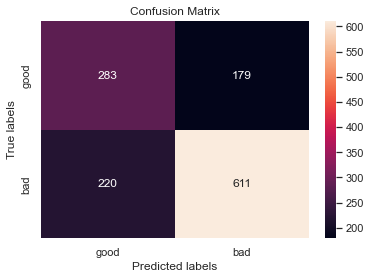

In [22]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
o = {}
for C in [0.000001, 0.00001, 0.0001, 0.001, 0.1, 1, 10, 10000]:
    clf = SGDClassifier(loss='log', penalty='l2',alpha=0.001, learning_rate='adaptive',eta0=0.01,max_iter=1000000)

    samples =  len(y_train)
    o[C] = train_predict_evaluate(clf, samples, X_train, y_train, X_test, y_test)
    
print(o)    

(5170, 455)


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


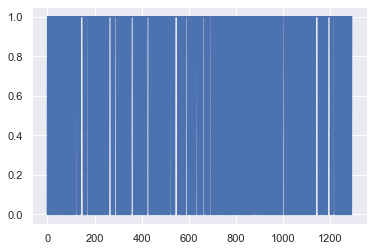

LogisticRegression trained on 5170 samples.


{'train_time': 21.683854818344116,
 'pred_time': 0.14648008346557617,
 'acc_train': 0.78,
 'acc_test': 0.7633410672853829,
 'f_train': 0.78,
 'f_test': 0.7633410672853829}

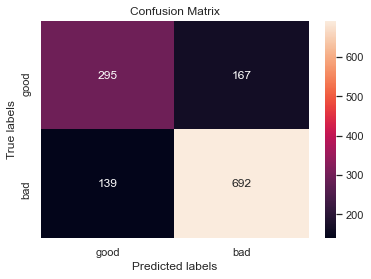

In [38]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', max_iter=1000000)
samples =  len(y_train)
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3)
X_train_scaled = poly.fit_transform(X_train)
X_test_scaled = poly.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)
print(X_train_scaled.shape)
train_predict_evaluate(clf, samples, X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def entrena_prediu_evalua(model, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: el objecte que s'entrenarà
       - sample_size: el número de mostres del training set que es farán servir (en %)
       - X_train: caracteristiques entrenament
       - y_train: etiqueta entrenament
       - X_test: caracteristiques test
       - y_test: etiqueta test
    '''
    
    results = {}

    """
    Entrenar el model tenint en compte el 'sample_size' 
    """

    
    """
    Obtenir les prediccions del model sobre el conjunt d'entrenament i sobre el conjunt de test
    """
    
    """
    Calcular el accuracy i el F1-score del train i del test
    """

    print("{} s'ha entrenat amb el {}% de mostres.".format(model.__class__.__name__, sample_size * 100))
    
    
    return results

clf = LogisticRegression()
samples = 1  # utilitza valors com 0.01, 0.1 o 1, que hauran de equivaldre a 1%, 10%, 100%
results = entrena_prediu_evalua(clf, samples, X_train, y_train, X_test, y_test)

## B. Regularitzadors (40%)

* Descriu el parametre **penalty** de LogisticRegression {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}

* Hi ha alguna regularitzador que no està implementat en segons quin **solver**. Haureu de trobar la combinació que funciona.

* Què representen els atributs *coef_* i *intercept_*. Mostra'ls. Hi veus alguna diferencia depenen del regularitzador utilitzat?

* Què fa el parametre *C*. En quins casos afecta? Fes una taula mostrant els resultats.



## C. Demostració Error de Bias (20%)

* Què hem de fer per veure que el model que estem provant té un error de bias molt alt? (es a dir, model simple)

* Què passa si fem servir poques dades per entrenar? (mostra com varien els resultats segons % de entrenament)

* I si utilitzem poques iteracions limitant el *max_iter*


## D. Demostració Error de Variance (20%)

* Què hem de fer per veure que el model que estem provant té un error de variança molt alt? (es a dir, model massa complexe)

* Crea models de features més complexes amb [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

* Podem reduir el error de variança si enlloc de classificar el vi blanc i el negre, els separessim?

* Sabrieu explicar-me aquesta [gráfica](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)? Podeu generar-la amb aquestes dades de entrenament?

